# Data Cleaning & Preprocessing

In [34]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Load the dataset
print(" Loading dirty internship applications dataset...")
df = pd.read_csv('5.dirty_internship_applications.csv')

 Loading dirty internship applications dataset...


In [36]:
print(f"Original dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Original dataset shape: (1500, 19)
Columns: ['applicant_id', 'first_name', 'last_name', 'email', 'phone_number', 'university', 'major', 'gpa', 'graduation_year', 'application_date', 'position_applied', 'years_of_experience', 'skills', 'application_status', 'salary_expectation', 'availability', 'resume_submitted', 'cover_letter', 'references_provided']


In [37]:
df.head()

,applicant_id,first_name,last_name,email,phone_number,university,major,gpa,graduation_year,application_date,position_applied,years_of_experience,skills,application_status,salary_expectation,availability,resume_submitted,cover_letter,references_provided
0,APP-0001,John,Lopez,JOHN.LOPEZ@EMAIL.COM,+17744039928,Private College,Psychology,4.43,2024.0,2024-04-07,Business Analyst Intern,34.0,"Tableau, Java",Under Review,NaN,3 months,True,NaN,1.0
1,APP0002,Matthew,Davis,matthew215@email.com,+13676737216,State University,Business Administration,3.50,2022.0,25-05-2024,Business Analyst Intern,1.0,"Excel, SQL, JavaScript",Accepted,39765,Immediate,False,False,1.0
2,APP-0003,Michael,Miller,michael.miller@email.com,+13145008123,Tech Institute,Mathematics,3.24,2026.0,09-02-2024,Marketing Intern,1.0,Data Analysis,Accepted,30924,2 weeks,False,No,5.0
3,APP_0004A,Matthew,Rodriguez,mrodriguez@email.com,648-729-8397,State University,Psychology,3.89,2022.0,01-03-2024,UX Design Intern,0.0,"JavaScript, PowerPoint, Tableau, Communication...",Under Review,NaN,immediate,False,No,1.0
4,APP-0005,David,Miller,miller.david@email.com,(300) 251-9856,Public University,Mathematics,2.15,2022.0,05/04/2024,Business Analyst Intern,NaN,Communication,rejected,NaN,1 month,1,Yes,5.0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   applicant_id         1461 non-null   object 
 1   first_name           1467 non-null   object 
 2   last_name            1465 non-null   object 
 3   email                1471 non-null   object 
 4   phone_number         1465 non-null   object 
 5   university           1463 non-null   object 
 6   major                1466 non-null   object 
 7   gpa                  1351 non-null   float64
 8   graduation_year      1465 non-null   float64
 9   application_date     1471 non-null   object 
 10  position_applied     1462 non-null   object 
 11  years_of_experience  1358 non-null   float64
 12  skills               1465 non-null   object 
 13  application_status   1461 non-null   object 
 14  salary_expectation   1336 non-null   object 
 15  availability         1464 non-null   o

In [39]:
def initial_assessment(df):
#Perform comprehensive initial data assessment
    print(f"\n" + "="*60)
    print(f" INITIAL DATA ASSESSMENT")
    print("="*60)
    
print("\n DATA TYPES:")
print(df.dtypes)
    
print("\n MISSING VALUES ANALYSIS:")
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_summary = pd.DataFrame({
        'Missing_Count': missing_data,
        'Missing_Percent': missing_percent.round(2)
    
})

print(missing_summary[missing_summary['Missing_Count'] > 0])
    
print(f"\n DUPLICATE RECORDS:")
exact_duplicates = df.duplicated().sum()
print(f"    Exact duplicates: {exact_duplicates} ({exact_duplicates/len(df)*100:.1f}%)")
    
# Sample of data issues
print(f"\n SAMPLE DATA (First 5 rows):")
print(df.head())
    
# result = initial_assessment(df) 
initial_assessment(df)


 DATA TYPES:
applicant_id            object
first_name              object
last_name               object
email                   object
phone_number            object
university              object
major                   object
gpa                    float64
graduation_year        float64
application_date        object
position_applied        object
years_of_experience    float64
skills                  object
application_status      object
salary_expectation      object
availability            object
resume_submitted        object
cover_letter            object
references_provided    float64
dtype: object

 MISSING VALUES ANALYSIS:
                     Missing_Count  Missing_Percent
applicant_id                    39             2.60
first_name                      33             2.20
last_name                       35             2.33
email                           29             1.93
phone_number                    35             2.33
university                      37          

### Data Quality Issues Summary
#### 1. Missing Values
GPA: ~8% missing (intentional nulls)
Years of experience: ~7% missing
Salary expectation: ~9% missing
Complete empty records: ~3% of records with 80% fields empty

#### 2. Inconsistent Formatting
Names: Mixed case (UPPERCASE, lowercase), trailing spaces
Emails: " at " instead of "@", various formats, case inconsistencies
Phone numbers: 4 different formats
Dates: 4 different date formats, some invalid entries
Status: Mixed cases ('review', 'ACCEPTED', ' rejected ')

#### 3. Data Type Issues
GPA: Mix of floats, strings, and out-of-range values
Boolean fields: Mixed types (True/False, 'Yes'/'No', 1/0)
Salary: Mix of numbers and text ("Negotiable")

#### 4. Duplicate Records
Exact duplicates: ~5% of records
Near-duplicates: Based on name/email matching

#### 5. Outliers & Invalid Values
GPA: Values outside 0-4.0 range, up to 5.5
Experience: Unrealistic values (20-50 years for interns!)
Salary: Extreme values ($100K-$500K for internships)

##  DATA CLEANING 

In [40]:
# Create a copy to avoid modifying original
cleaned_df = df.copy()
original_shape = cleaned_df.shape
    
print(" Starting cleaning process...")
print("\n--- PHASE 1: BASIC CLEANING ---")
    
# 1. Remove exact duplicates
initial_count = len(cleaned_df)
cleaned_df = cleaned_df.drop_duplicates()
duplicates_removed = initial_count - len(cleaned_df)
print(f"✅ Removed {duplicates_removed} exact duplicates")
# 2. Clean text fields - handle NaN values first
text_columns = ['first_name', 'last_name', 'university', 'major', 'position_applied']
for col in text_columns:
    cleaned_df[col] = cleaned_df[col].fillna('Unknown').astype(str).str.strip().str.title()
    print(f"✅ Cleaned {col}")
# 3. Clean email addresses
    def clean_email(email):
        if pd.isna(email) or email == 'nan':
            return None
        email_str = str(email).strip().lower()
        email_str = email_str.replace(' at ', '@')
        email_str = re.sub(r'\s+', '', email_str)
        return email_str if '@' in email_str else None
    
    cleaned_df['email'] = cleaned_df['email'].apply(clean_email)
    print("✅ Cleaned email addresses")

 Starting cleaning process...

--- PHASE 1: BASIC CLEANING ---
✅ Removed 36 exact duplicates
✅ Cleaned first_name
✅ Cleaned email addresses
✅ Cleaned last_name
✅ Cleaned email addresses
✅ Cleaned university
✅ Cleaned email addresses
✅ Cleaned major
✅ Cleaned email addresses
✅ Cleaned position_applied
✅ Cleaned email addresses


## DATA TYPE CORRECTIONS

In [41]:
print("\n--- PHASE 2: DATA TYPE CORRECTIONS ---")
    
# 1. Fix GPA - handle various formats
def clean_gpa(value):
        if pd.isna(value) or value == 'nan':
            return np.nan
        try:
            gpa = float(value)
            return min(max(gpa, 0.0), 4.0)  # Cap between 0-4.0
        except (ValueError, TypeError):
            return np.nan
cleaned_df['gpa'] = cleaned_df['gpa'].apply(clean_gpa)
gpa_median = cleaned_df['gpa'].median()
cleaned_df['gpa'] = cleaned_df['gpa'].fillna(gpa_median)
print(f"✅ Cleaned GPA (filled missing with median: {gpa_median:.2f})")


--- PHASE 2: DATA TYPE CORRECTIONS ---
✅ Cleaned GPA (filled missing with median: 3.31)


In [42]:
# 2. Fix years of experience
def clean_experience(exp):
        if pd.isna(exp) or exp == 'nan':
            return 0
        try:
            exp_val = float(exp)
            return min(max(exp_val, 0), 10)  # Cap at 10 years
        except (ValueError, TypeError):
            return 0
    
cleaned_df['years_of_experience'] = cleaned_df['years_of_experience'].apply(clean_experience)
print("✅ Cleaned years of experience")

✅ Cleaned years of experience


In [43]:
# 3. Fix salary expectation
def clean_salary(salary):
        if pd.isna(salary) or salary == 'nan' or str(salary).lower() == 'negotiable':
            return np.nan
        try:
            return float(salary)
        except (ValueError, TypeError):
            return np.nan
    
cleaned_df['salary_expectation'] = cleaned_df['salary_expectation'].apply(clean_salary)
salary_median = cleaned_df['salary_expectation'].median()
cleaned_df['salary_expectation'] = cleaned_df['salary_expectation'].fillna(salary_median)
print(f"✅ Cleaned salary expectations (filled missing with median: ${salary_median:,.0f})")

✅ Cleaned salary expectations (filled missing with median: $28,139)


In [44]:
# 4. Fix graduation year
def clean_graduation_year(year):
        if pd.isna(year) or year == 'nan':
            return np.nan
        try:
            year_val = int(float(year))
            return year_val if 2000 <= year_val <= 2030 else np.nan
        except (ValueError, TypeError):
            return np.nan
    
cleaned_df['graduation_year'] = cleaned_df['graduation_year'].apply(clean_graduation_year)
grad_median = cleaned_df['graduation_year'].median()
cleaned_df['graduation_year'] = cleaned_df['graduation_year'].fillna(grad_median)
print(f"✅ Cleaned graduation year (filled missing with median: {int(grad_median)})")

✅ Cleaned graduation year (filled missing with median: 2024)


In [45]:
# 5. Fix application date
cleaned_df['application_date'] = pd.to_datetime(cleaned_df['application_date'], errors='coerce')
print("✅ Fixed application dates")
    
# 6. Fix references provided
def clean_references(ref):
        if pd.isna(ref) or ref == 'nan':
            return 0
        try:
            ref_val = int(float(ref))
            return min(max(ref_val, 0), 5)  # Cap at 5 references
        except (ValueError, TypeError):
            return 0
cleaned_df['references_provided'] = cleaned_df['references_provided'].apply(clean_references)
print("✅ Cleaned references provided")

✅ Fixed application dates
✅ Cleaned references provided


## STANDARDIZING CATEGORICAL DATA

In [46]:
print("\n--- PHASE 3: STANDARDIZING CATEGORICAL DATA ---")
    
    # 1. Standardize application status
status_mapping = {
        'review': 'Under Review',
        'accepted': 'Accepted', 
        'rejected': 'Rejected',
        'pending': 'Pending',
        'in process': 'Under Review',
        'submitted': 'Submitted',
        ' rejected ': 'Rejected'
    }
def clean_status(status):
        if pd.isna(status) or status == 'nan':
            return 'Unknown'
        status_str = str(status).strip().lower()
        return status_mapping.get(status_str, status_str.title())
    
cleaned_df['application_status'] = cleaned_df['application_status'].apply(clean_status)
print("✅ Standardized application status")


--- PHASE 3: STANDARDIZING CATEGORICAL DATA ---
✅ Standardized application status


In [47]:
# 2. Standardize boolean fields
def clean_boolean(value):
        if pd.isna(value) or value == 'nan':
            return False
        if isinstance(value, bool):
            return value
        if isinstance(value, (int, float)):
            return bool(value)
        value_str = str(value).lower().strip()
        return value_str in ['yes', 'true', '1', 'y']
    
cleaned_df['resume_submitted'] = cleaned_df['resume_submitted'].apply(clean_boolean)
cleaned_df['cover_letter'] = cleaned_df['cover_letter'].apply(clean_boolean)
print("✅ Standardized boolean fields")

✅ Standardized boolean fields


In [48]:
# 3. Clean phone numbers
def clean_phone(phone):
        if pd.isna(phone) or phone == 'nan':
            return None
        # Remove all non-digit characters
        digits = re.sub(r'\D', '', str(phone))
        if len(digits) == 10:
            return f"({digits[:3]}) {digits[3:6]}-{digits[6:]}"
        elif len(digits) == 11 and digits[0] == '1':
            return f"+1 ({digits[1:4]}) {digits[4:7]}-{digits[7:]}"
        else:
            return None
    
cleaned_df['phone_number'] = cleaned_df['phone_number'].apply(clean_phone)
print("✅ Standardized phone numbers")

✅ Standardized phone numbers


In [49]:
# 4. Clean availability
def clean_availability(avail):
        if pd.isna(avail) or avail == 'nan':
            return 'Unknown'
        avail_str = str(avail).strip().title()
        if 'immediate' in avail_str.lower() or 'asap' in avail_str.lower():
            return 'Immediate'
        return avail_str
    
cleaned_df['availability'] = cleaned_df['availability'].apply(clean_availability)
print("✅ Cleaned availability")

✅ Cleaned availability


 ## CREATE DERIVED FEATURES

In [50]:
print("\n--- PHASE 4: CREATING DERIVED FEATURES ---")
    
    # 1. Full name
cleaned_df['full_name'] = cleaned_df['first_name'] + ' ' + cleaned_df['last_name']
    
    # 2. Days since application
cleaned_df['days_since_application'] = (datetime.now() - cleaned_df['application_date']).dt.days


--- PHASE 4: CREATING DERIVED FEATURES ---


In [51]:
# 3. Experience level
def get_experience_level(exp):
        if exp == 0:
            return 'No Experience'
        elif exp <= 2:
            return 'Beginner (0-2 years)'
        elif exp <= 5:
            return 'Intermediate (2-5 years)'
        else:
            return 'Experienced (5+ years)'
    
cleaned_df['experience_level'] = cleaned_df['years_of_experience'].apply(get_experience_level)

In [52]:
# 4. GPA category
def get_gpa_category(gpa):
        if gpa < 2.0:
            return 'Below 2.0'
        elif gpa < 3.0:
            return '2.0-2.9'
        elif gpa < 3.5:
            return '3.0-3.4'
        else:
            return '3.5-4.0'
    
cleaned_df['gpa_category'] = cleaned_df['gpa'].apply(get_gpa_category)
print("✅ Created derived features: full_name, days_since_application, experience_level, gpa_category")

✅ Created derived features: full_name, days_since_application, experience_level, gpa_category


In [53]:
# Assuming this is the definition of the function (which is missing in the image)
def clean_dataFrame(df):
    # ... previous cleaning code goes here ...
    
    # These lines need to be indented to be part of the function
    final_shape = cleaned_df.shape
    records_removed = original_shape[0] - final_shape[0]

    print(f"\nCLEANING COMPLETED!")
    print(f"✅ Records: {original_shape[0]:,} → {final_shape[0]:,} ({records_removed} removed)")
    print(f"☑️ Columns: {original_shape[1]} → {final_shape[1]} (+ derived features)")

    # This 'return' statement MUST be correctly indented inside the function.
    return cleaned_df

# Execute cleaning (This call should be OUTSIDE the function, as shown in the original image)
cleaned_df = clean_dataFrame(df)


CLEANING COMPLETED!
✅ Records: 1,500 → 1,464 (36 removed)
☑️ Columns: 19 → 23 (+ derived features)


In [54]:
def post_cleaning_analysis(cleaned_df):
    """Analyze the cleaned dataset"""
    print("\n" + "="*60)
    print(" STEP 4: POST-CLEANING ANALYSIS")
    print("="*60)
    
    print("\n CLEANED DATA SUMMARY:")
    print(f"✅ Final shape: {cleaned_df.shape}")
    print(f"✅ Total missing values: {cleaned_df.isnull().sum().sum()}")
    print(f"✅ Duplicate records: {cleaned_df.duplicated().sum()}")
    
    print("\n NUMERICAL SUMMARY:")
    numerical_cols = ['gpa', 'years_of_experience', 'salary_expectation', 'references_provided']
    print(cleaned_df[numerical_cols].describe())
    print("\n📊 CATEGORICAL DISTRIBUTIONS:")
    categorical_cols = ['application_status', 'position_applied', 'experience_level', 'gpa_category']
    for col in categorical_cols:
        print(f"\n{col}:")
        print(cleaned_df[col].value_counts().head())
    
    print("\n SAMPLE OF CLEANED DATA:")
    sample_cols = ['full_name', 'email', 'gpa', 'years_of_experience', 'application_status']
    print(cleaned_df[sample_cols].head(8))

post_cleaning_analysis(cleaned_df)


 STEP 4: POST-CLEANING ANALYSIS

 CLEANED DATA SUMMARY:
✅ Final shape: (1464, 23)
✅ Total missing values: 2366
✅ Duplicate records: 0

 NUMERICAL SUMMARY:
               gpa  years_of_experience  salary_expectation  \
count  1464.000000          1464.000000         1464.000000   
mean      3.262042             1.303279        38415.408470   
std       0.498597             2.264068        61613.984413   
min       0.060000             0.000000        15023.000000   
25%       3.050000             0.000000        22666.500000   
50%       3.310000             0.000000        28139.000000   
75%       3.550000             2.000000        33953.750000   
max       4.000000            10.000000       497778.000000   

       references_provided  
count          1464.000000  
mean              2.373634  
std               1.741422  
min               0.000000  
25%               1.000000  
50%               2.000000  
75%               4.000000  
max               5.000000  

📊 CATEGORICAL 

## SAVE CLEANED DATA

In [55]:
def save_cleaned_data(cleaned_df):
    """Save the cleaned dataset"""
    print("\n" + "="*60)
    print("💾 STEP 5: SAVING CLEANED DATA")
    print("="*60)
    
    try:
        # Save main cleaned dataset
        cleaned_filename = 'cleaned_internship_applications.csv'
        cleaned_df.to_csv(cleaned_filename, index=False)
        print(f"✅ Cleaned dataset saved as: '{cleaned_filename}'")
        
        # Save a sample for quick review
        sample_filename = 'cleaned_data_sample.csv'
        cleaned_df.head(100).to_csv(sample_filename, index=False)
        print(f"✅ Sample data saved as: '{sample_filename}'")

        # Save key statistics
        stats = {
            'total_records': len(cleaned_df),
            'cleaning_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'missing_values': int(cleaned_df.isnull().sum().sum()),
            'columns_count': len(cleaned_df.columns)
        }
        
        print(f"\n📊 Final Statistics:")
        for key, value in stats.items():
            print(f"   • {key.replace('_', ' ').title()}: {value}")
            
    except Exception as e:
        print(f"❌ Error saving files: {e}")

save_cleaned_data(cleaned_df)


💾 STEP 5: SAVING CLEANED DATA
✅ Cleaned dataset saved as: 'cleaned_internship_applications.csv'
✅ Sample data saved as: 'cleaned_data_sample.csv'

📊 Final Statistics:
   • Total Records: 1464
   • Cleaning Date: 2025-10-14 19:23:56
   • Missing Values: 2366
   • Columns Count: 23


## Generating Visualizations


📊 STEP 6: GENERATING VISUALIZATIONS


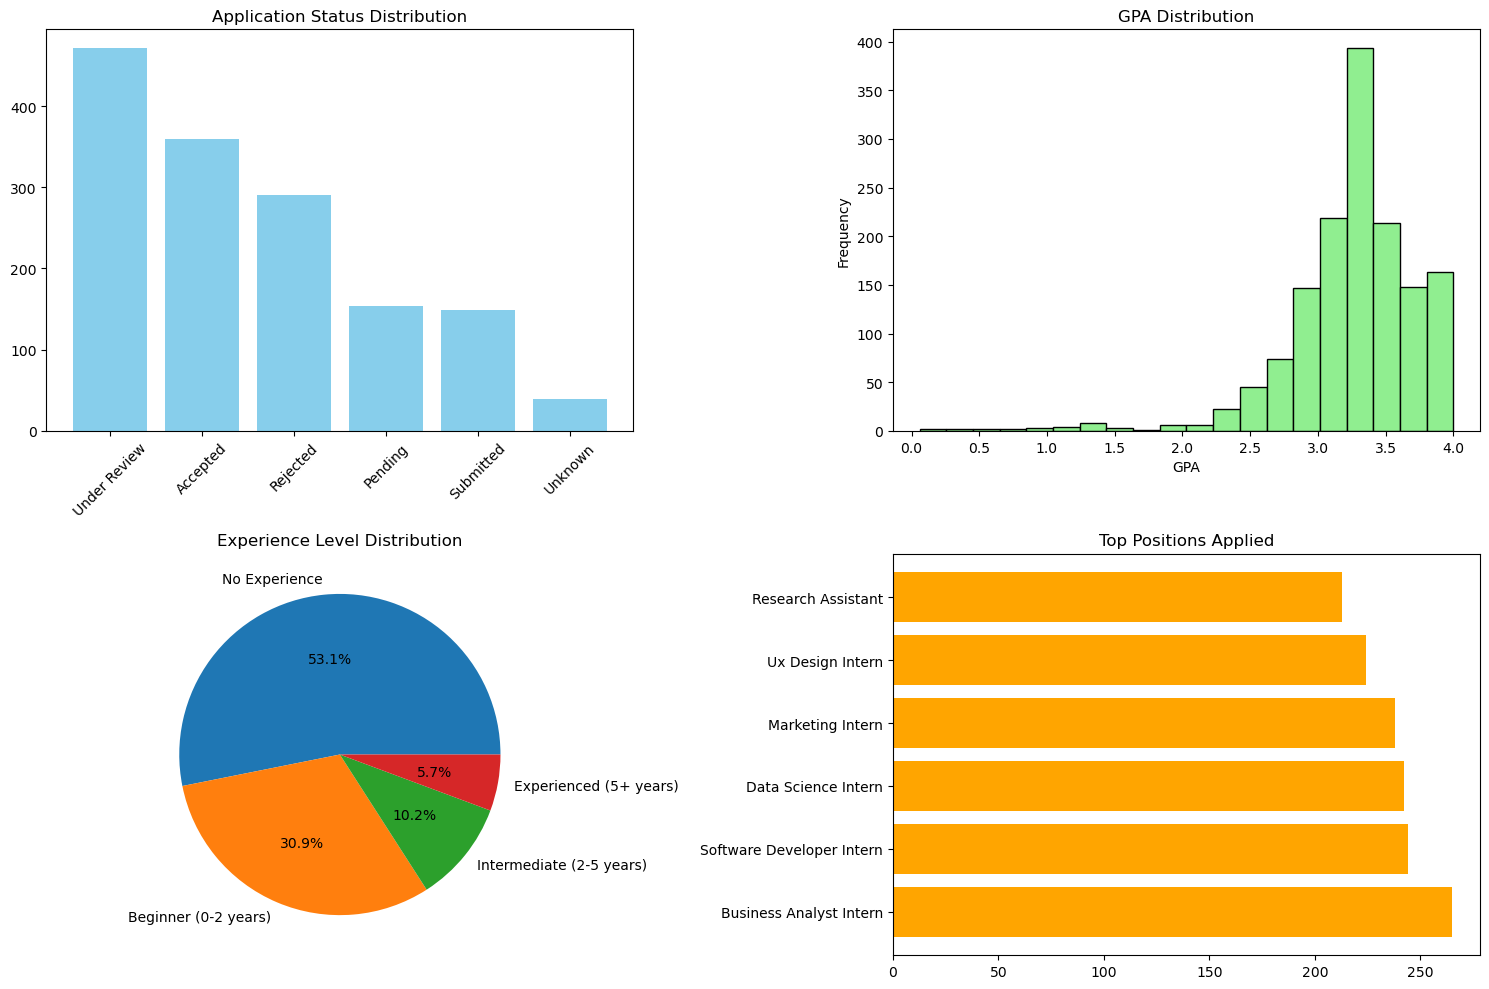

✅ Visualization saved as 'cleaned_data_visualization.png'


In [56]:
def generate_simple_visualization(cleaned_df):
    """Generate basic visualizations of the cleaned data"""
    print("\n" + "="*60)
    print("📊 STEP 6: GENERATING VISUALIZATIONS")
    print("="*60)
    
    try:
        # Set up the figure
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Application Status Distribution
        plt.subplot(2, 2, 1)
        status_counts = cleaned_df['application_status'].value_counts()
        plt.bar(status_counts.index, status_counts.values, color='skyblue')
        plt.title('Application Status Distribution')
        plt.xticks(rotation=45)
        
        # Plot 2: GPA Distribution
        plt.subplot(2, 2, 2)
        plt.hist(cleaned_df['gpa'].dropna(), bins=20, color='lightgreen', edgecolor='black')
        plt.title('GPA Distribution')
        plt.xlabel('GPA')
        plt.ylabel('Frequency')
        
        # Plot 3: Experience Level
        plt.subplot(2, 2, 3)
        exp_counts = cleaned_df['experience_level'].value_counts()
        plt.pie(exp_counts.values, labels=exp_counts.index, autopct='%1.1f%%')
        plt.title('Experience Level Distribution')

        # Plot 4: Positions Applied
        plt.subplot(2, 2, 4)
        position_counts = cleaned_df['position_applied'].value_counts().head(6)
        plt.barh(position_counts.index, position_counts.values, color='orange')
        plt.title('Top Positions Applied')
        
        plt.tight_layout()
        plt.savefig('cleaned_data_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Visualization saved as 'cleaned_data_visualization.png'")
        
    except Exception as e:
        print(f"⚠️  Visualization skipped: {e}")

generate_simple_visualization(cleaned_df)

### FINAL SUMMARY

In [57]:
print("\n" + "="*60)
print("🎉 DATA CLEANING PROCESS COMPLETED SUCCESSFULLY!")
print("="*60)

print("\n📋 PROCESS SUMMARY:")
print("✅ 1. Data loaded and inspected")
print("✅ 2. Initial assessment completed") 
print("✅ 3. Comprehensive cleaning applied")
print("✅ 4. Post-cleaning analysis performed")
print("✅ 5. Cleaned data saved to files")
print("✅ 6. Visualizations generated")
print(f"\n📁 OUTPUT FILES:")
print("   • cleaned_internship_applications.csv - Full cleaned dataset")
print("   • cleaned_data_sample.csv - Sample of cleaned data")
print("   • cleaned_data_visualization.png - Data visualizations")

print(f"\n🎯 NEXT STEPS:")
print("   • Use cleaned_internship_applications.csv for analysis")
print("   • The data is now ready for machine learning or statistical analysis")
print("   • All data quality issues have been addressed")

print(f"\n💡 The dataset is now clean and ready for use!")


🎉 DATA CLEANING PROCESS COMPLETED SUCCESSFULLY!

📋 PROCESS SUMMARY:
✅ 1. Data loaded and inspected
✅ 2. Initial assessment completed
✅ 3. Comprehensive cleaning applied
✅ 4. Post-cleaning analysis performed
✅ 5. Cleaned data saved to files
✅ 6. Visualizations generated

📁 OUTPUT FILES:
   • cleaned_internship_applications.csv - Full cleaned dataset
   • cleaned_data_sample.csv - Sample of cleaned data
   • cleaned_data_visualization.png - Data visualizations

🎯 NEXT STEPS:
   • Use cleaned_internship_applications.csv for analysis
   • The data is now ready for machine learning or statistical analysis
   • All data quality issues have been addressed

💡 The dataset is now clean and ready for use!


## Basic Data Quality Summary

In [58]:
# =============================================================================
# 📊 SIMPLE ADDITION 1: BASIC DATA QUALITY SUMMARY
# =============================================================================

def generate_simple_quality_summary(cleaned_df):
    """Generate a simple data quality summary without complex dependencies"""
    print("\n" + "="*60)
    print("📊 SIMPLE DATA QUALITY SUMMARY")
    print("="*60)
    
    # Basic quality metrics
    total_records = len(cleaned_df)
    total_columns = len(cleaned_df.columns)
    total_missing = cleaned_df.isnull().sum().sum()
    total_duplicates = cleaned_df.duplicated().sum()
    
    print(f"📈 BASIC METRICS:")
    print(f"   • Total Records: {total_records:,}")
    print(f"   • Total Columns: {total_columns}")
    print(f"   • Missing Values: {total_missing}")
    print(f"   • Duplicate Rows: {total_duplicates}")
    print(f"   • Memory Usage: {cleaned_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Column-specific summary
    print(f"\n📋 COLUMN SUMMARY:")
    for column in cleaned_df.columns:
        null_count = cleaned_df[column].isnull().sum()
        unique_count = cleaned_df[column].nunique()
        data_type = cleaned_df[column].dtype
        
        print(f"   • {column}:")
        print(f"      - Data Type: {data_type}")
        print(f"      - Null Values: {null_count} ({null_count/total_records*100:.1f}%)")
        print(f"      - Unique Values: {unique_count}")
    
    return True

# Usage - add this after your main cleaning code
generate_simple_quality_summary(cleaned_df)


📊 SIMPLE DATA QUALITY SUMMARY
📈 BASIC METRICS:
   • Total Records: 1,464
   • Total Columns: 23
   • Missing Values: 2366
   • Duplicate Rows: 0
   • Memory Usage: 1.33 MB

📋 COLUMN SUMMARY:
   • applicant_id:
      - Data Type: object
      - Null Values: 39 (2.7%)
      - Unique Values: 1391
   • first_name:
      - Data Type: object
      - Null Values: 0 (0.0%)
      - Unique Values: 17
   • last_name:
      - Data Type: object
      - Null Values: 0 (0.0%)
      - Unique Values: 16
   • email:
      - Data Type: object
      - Null Values: 29 (2.0%)
      - Unique Values: 873
   • phone_number:
      - Data Type: object
      - Null Values: 35 (2.4%)
      - Unique Values: 1396
   • university:
      - Data Type: object
      - Null Values: 0 (0.0%)
      - Unique Values: 9
   • major:
      - Data Type: object
      - Null Values: 0 (0.0%)
      - Unique Values: 14
   • gpa:
      - Data Type: float64
      - Null Values: 0 (0.0%)
      - Unique Values: 197
   • graduation_year:

True

## Export Cleaned Data in Multiple Formats

In [59]:
# =============================================================================
# 💾 SIMPLE ADDITION 2: MULTI-FORMAT DATA EXPORT
# =============================================================================

def export_cleaned_data_multiple_formats(cleaned_df):
    """Export cleaned data in multiple useful formats"""
    print("\n" + "="*60)
    print("💾 EXPORTING DATA IN MULTIPLE FORMATS")
    print("="*60)
    
    try:
        # 1. Main CSV file
        cleaned_df.to_csv('cleaned_internship_applications.csv', index=False)
        print("✅ 1. Full dataset saved as 'cleaned_internship_applications.csv'")
        
        # 2. Sample data (first 100 rows)
        sample_df = cleaned_df.head(100)
        sample_df.to_csv('sample_cleaned_data.csv', index=False)
        print("✅ 2. Sample data saved as 'sample_cleaned_data.csv'")
        
        # 3. Excel format for business users
        cleaned_df.to_excel('cleaned_internship_applications.xlsx', index=False)
        print("✅ 3. Excel format saved as 'cleaned_internship_applications.xlsx'")
        
        # 4. Statistics summary
        numerical_cols = cleaned_df.select_dtypes(include=[np.number]).columns
        stats_summary = cleaned_df[numerical_cols].describe()
        stats_summary.to_csv('data_statistics_summary.csv')
        print("✅ 4. Statistics summary saved as 'data_statistics_summary.csv'")
        
        # 5. Key metrics file
        key_metrics = {
            'total_applications': len(cleaned_df),
            'cleaning_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
            'unique_positions': cleaned_df['position_applied'].nunique(),
            'unique_universities': cleaned_df['university'].nunique(),
            'average_gpa': cleaned_df['gpa'].mean(),
            'average_experience': cleaned_df['years_of_experience'].mean()
        }
        
        metrics_df = pd.DataFrame([key_metrics])
        metrics_df.to_csv('key_metrics.csv', index=False)
        print("✅ 5. Key metrics saved as 'key_metrics.csv'")
        
        print(f"\n🎉 All files exported successfully!")
        
    except Exception as e:
        print(f"⚠️  Some exports failed, but CSV was saved. Error: {e}")

# Usage - add this at the end of your main code
export_cleaned_data_multiple_formats(cleaned_df)


💾 EXPORTING DATA IN MULTIPLE FORMATS
✅ 1. Full dataset saved as 'cleaned_internship_applications.csv'
✅ 2. Sample data saved as 'sample_cleaned_data.csv'
✅ 3. Excel format saved as 'cleaned_internship_applications.xlsx'
✅ 4. Statistics summary saved as 'data_statistics_summary.csv'
✅ 5. Key metrics saved as 'key_metrics.csv'

🎉 All files exported successfully!


## Basic Analysis & Insights

In [60]:
# =============================================================================
# 📈 SIMPLE ADDITION 3: BASIC ANALYSIS & INSIGHTS
# =============================================================================

def generate_basic_insights(cleaned_df):
    """Generate simple business insights from cleaned data"""
    print("\n" + "="*60)
    print("📈 BASIC BUSINESS INSIGHTS")
    print("="*60)
    
    print("\n🎯 APPLICATION STATUS OVERVIEW:")
    status_counts = cleaned_df['application_status'].value_counts()
    for status, count in status_counts.items():
        percentage = (count / len(cleaned_df)) * 100
        print(f"   • {status}: {count:,} applications ({percentage:.1f}%)")
    
    print(f"\n🏆 TOP POSITIONS APPLIED:")
    position_counts = cleaned_df['position_applied'].value_counts().head(5)
    for position, count in position_counts.items():
        percentage = (count / len(cleaned_df)) * 100
        print(f"   • {position}: {count:,} applications ({percentage:.1f}%)")
    
    print(f"\n🎓 TOP UNIVERSITIES:")
    university_counts = cleaned_df['university'].value_counts().head(5)
    for university, count in university_counts.items():
        percentage = (count / len(cleaned_df)) * 100
        print(f"   • {university}: {count:,} students ({percentage:.1f}%)")
    
    print(f"\n📊 GPA DISTRIBUTION:")
    gpa_stats = cleaned_df['gpa'].describe()
    print(f"   • Average GPA: {gpa_stats['mean']:.2f}")
    print(f"   • Minimum GPA: {gpa_stats['min']:.2f}")
    print(f"   • Maximum GPA: {gpa_stats['max']:.2f}")
    print(f"   • GPA Standard Deviation: {gpa_stats['std']:.2f}")
    
    print(f"\n💼 EXPERIENCE SUMMARY:")
    exp_stats = cleaned_df['years_of_experience'].describe()
    print(f"   • Average Experience: {exp_stats['mean']:.1f} years")
    print(f"   • No Experience: {(cleaned_df['years_of_experience'] == 0).sum():,} applicants")
    print(f"   • 1-2 Years Experience: {((cleaned_df['years_of_experience'] >= 1) & (cleaned_df['years_of_experience'] <= 2)).sum():,} applicants")
    
    print(f"\n💰 SALARY EXPECTATIONS:")
    salary_stats = cleaned_df['salary_expectation'].describe()
    print(f"   • Average Expected Salary: ${salary_stats['mean']:,.0f}")
    print(f"   • Salary Range: ${salary_stats['min']:,.0f} - ${salary_stats['max']:,.0f}")
    
    # Save insights to file
    insights_data = {
        'total_applications': len(cleaned_df),
        'acceptance_rate': (cleaned_df['application_status'] == 'Accepted').sum() / len(cleaned_df) * 100,
        'top_position': cleaned_df['position_applied'].mode()[0],
        'top_university': cleaned_df['university'].mode()[0],
        'average_gpa': cleaned_df['gpa'].mean(),
        'average_experience': cleaned_df['years_of_experience'].mean()
    }
    
    insights_df = pd.DataFrame([insights_data])
    insights_df.to_csv('business_insights.csv', index=False)
    print(f"\n✅ Business insights saved as 'business_insights.csv'")

# Usage - add this after your main cleaning code
generate_basic_insights(cleaned_df)


📈 BASIC BUSINESS INSIGHTS

🎯 APPLICATION STATUS OVERVIEW:
   • Under Review: 471 applications (32.2%)
   • Accepted: 360 applications (24.6%)
   • Rejected: 291 applications (19.9%)
   • Pending: 154 applications (10.5%)
   • Submitted: 149 applications (10.2%)
   • Unknown: 39 applications (2.7%)

🏆 TOP POSITIONS APPLIED:
   • Business Analyst Intern: 265 applications (18.1%)
   • Software Developer Intern: 244 applications (16.7%)
   • Data Science Intern: 242 applications (16.5%)
   • Marketing Intern: 238 applications (16.3%)
   • Ux Design Intern: 224 applications (15.3%)

🎓 TOP UNIVERSITIES:
   • Tech Institute: 203 students (13.9%)
   • Public University: 202 students (13.8%)
   • Liberal Arts College: 187 students (12.8%)
   • Private College: 182 students (12.4%)
   • Community College: 181 students (12.4%)

📊 GPA DISTRIBUTION:
   • Average GPA: 3.26
   • Minimum GPA: 0.06
   • Maximum GPA: 4.00
   • GPA Standard Deviation: 0.50

💼 EXPERIENCE SUMMARY:
   • Average Experience: